# Imports

In [1]:
import torch, sys, math, wandb
import numpy as np
from IPython.core.debugger import set_trace
from torch.autograd import Variable
from torchviz import make_dot
import torch.nn.functional as F
from tqdm.notebook import tqdm

import plotly.express as px
import plotly.graph_objects as go

In [2]:
wandb.init(project="mixture_of_experts", entity="zrosenberg")
config = wandb.config

wandb: Currently logged in as: zrosenberg (use `wandb login --relogin` to force relogin)


# Generate Data

We want to create a dataset that effectively combine data from two very different functions.

- Dataset one comes from a sinusoidal function, and oscillates between -1 and 1. To fit this data, a model requires a non-linearity. 
- Dataset two comes from a linear function. To fit this data, a model simply requires having the same domain as the data.

In [73]:
def sinusoidal_data(x):
    return np.sin(x)**3

def linear_data(x):
    return -1*x

def create_mixed_data(n_datapoints, min_value=-5, max_value=5, data_mix=.5):
    x = np.linspace(min_value, max_value, n_datapoints, dtype=np.float32)
    y_sin = sinusoidal_data(x)
    y_lin = linear_data(x)
    
    l_bound = (max_value - min_value)*data_mix/2 + min_value
    u_bound = max_value - (max_value - min_value)*data_mix/2
    
    y = np.where((x>=l_bound) & (x<=u_bound), y_sin, y_lin).astype(np.float32)
    
    return x[np.newaxis].T, y[np.newaxis].T

## Graph of functions

In [ ]:
x_graph = np.linspace(-5, 5, 500, dtype=np.float32)

In [31]:
px.line(x=x_graph, y=sinusoidal_data(x), title='Sinusoidal')

In [32]:
px.line(x=x_graph, y=linear_data(x), title='Linear')

In [79]:
x, y = create_mixed_data(5000)
px.line(x=x.squeeze(), y=y.squeeze(), title='Combined')

# Models

We effectively want three separate models: 2 "experts" and 1 "router" which will route the input data to the appropriate expert. 

To start off, instead of the router model actually routing, we'll feed the data to both experts, as well as the router. The router's output activation is a softmax, which will indicate which expert's output we ought to use. 

To simulate two experts in different domains, we'll have one expert capable of handling non-linear data, but only in the domain (-1, 1). The other expert will only be able to model linear data, but is not bound. 

The idea is the router ought to learn to route data between -1 and 1 to expert 1 while other data gets routed to expert 2.

In [98]:
# NN Layer that injects noise: https://discuss.pytorch.org/t/where-is-the-noise-layer-in-pytorch/2887/3
class GaussianNoise(torch.nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0.)

    def forward(self, x):
        if self.training and self.sigma != 0.:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x 

# Generic Regression Class
class Regression(torch.nn.Module):
    
    def __init__(self, input_dims, output_dims, output_activation=None, hidden_dims=250):
        super().__init__()
        self.input_layer  = torch.nn.Linear(input_dims, hidden_dims)
        self.h1           = torch.nn.Linear(hidden_dims, hidden_dims)
        self.output_layer = torch.nn.Linear(hidden_dims, output_dims)
        self.output_activation = output_activation
        
    def forward(self, x):
        out = self.input_layer(x)
        out = F.relu(out)
        
        out = self.h1(out)
        out = F.relu(out)
        
        out = self.output_layer(out)
        out = self.output_activation(out) if self.output_activation != None else out
        return out

# Router model will return a softmax, weighing how much weight to place on each expert
class Router(torch.nn.Module):
    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.input_layer  = torch.nn.Linear(input_dims, 25)
        self.noise_layer  = GaussianNoise()
        self.output_layer = torch.nn.Linear(25, output_dims)
        
    def forward(self, x):
        out = self.input_layer(x)
        out = F.relu(out)
        
#         out = self.noise_layer(out)
        
        out = self.output_layer(out)
        out = F.softmax(out, dim=1)
        return out

## Agent

Notes:

A loss function for te router, separate from the experts. Should include the actual error multiplied by the raw softmax value of the router. For instance, if the router output is [0.7, 0.3], expert_0's output goes forward. If the total error is 1, then the router error would be `0.7 * 1`.

In [130]:
class Agent():
    
    def __init__(self, dim_shape, lr=0.001, n_experts=2, log_wandb=False):
        self.input_dim, self.output_dim  = dim_shape

        self.experts = [Regression(self.input_dim, self.output_dim, hidden_dims=75) for _ in range(n_experts)]
        self.router_model = Router(self.input_dim, n_experts)
        
        # For logging
        self.log_wandb = log_wandb
        if log_wandb:
            for expert in self.experts:
                wandb.watch(expert)
            wandb.watch(self.router_model)
        
        model_params = []
        for expert in self.experts:
            model_params += expert.parameters()
        model_params += self.router_model.parameters()
        
        self.loss_fn   = torch.nn.MSELoss()
        self.optim = torch.optim.Adam(model_params, lr=lr)

        self.loss          = None
        self.losses        = []              
        self.expert_used   = []

    def predict(self, x, return_individual_predictions=False):
        x = torch.from_numpy(x)
        
        outs         = [expert(x) for expert in self.experts]
        out_combined = torch.cat(outs, 1)
        out_r        = self.router_model(x)

        predictions = (out_combined * out_r).sum(1).unsqueeze(1)
        
        if return_individual_predictions:
            return predictions.detach().numpy(), out_combined.detach().numpy(), out_r.detach().numpy()
        return predictions.detach().numpy()
        
    def fit(self, x, y, epochs=100, batch_size=None, graph_loss=True):
        
        # shuffle data
        shuffled_idx = np.arange(0, len(x))
        np.random.shuffle(shuffled_idx)
        
        x = x[shuffled_idx]
        y = y[shuffled_idx]
        
        batch_size = batch_size if batch_size != None else len(x) // 10
        
        with tqdm(total=epochs, file=sys.stdout) as pbar:
            for epoch in range(1, epochs+1):
                for batch in range((len(x) // batch_size) + 1):
                    
                    # *** NUMPY DATA => TORCH TENSORS ***
                    
                    # Get training batch and reshape to [[0], [1], ..., [n]]
                    x_train = x[batch * batch_size : (batch+1) * batch_size]#[np.newaxis].T
                    y_train = y[batch * batch_size : (batch+1) * batch_size]#[np.newaxis].T
                    # Convert to torch tensor
                    inputs  = Variable(torch.from_numpy(x_train))
                    labels  = Variable(torch.from_numpy(y_train))
                    
                    # *** TRAINING STEP ***
                    self.optim.zero_grad()
#                     set_trace()
                    outs         = [expert(inputs) for expert in self.experts]
                    out_combined = torch.cat(outs, 1)
                    out_r        = self.router_model(inputs)
                    predictions  = (out_combined * out_r).sum(1).unsqueeze(1)
                
                    loss      = self.loss_fn(predictions, labels)
                    self.loss = loss
                    loss.backward()
                    self.optim.step()
                    
                    # Save loss
                    if self.log_wandb:
                        wandb.log({"loss": loss})
                    self.losses.append(loss.item())
                    
                    # save which experts were used
                    self.expert_used.append(out_r.mean(0).detach().numpy())
                    
                # Update tqdm bar
                pbar.update(1)
                pbar.set_description(f'epoch loss: {np.nanmean(self.losses[-batch_size:])}')
        
        if graph_loss:
            fig = go.Figure()
            fig.update_layout(title=f"Final MSE Loss: {np.nanmean(self.losses[-10:])}")
            fig.add_trace(go.Scatter(y=self.losses, mode='lines', name='Loss'))
            fig.show()

    def validate(self, x, y):
        
        predictions, expert_usage, router_out = self.predict(x, return_individual_predictions=True)
        mse = np.mean((predictions - y)**2)
        
        fig = go.Figure()
        fig.update_layout(title=f"MSE Loss: {mse}")
        for i in range(expert_usage.shape[1]):
            fig.add_trace(go.Scatter(x=x.squeeze(), y=expert_usage[:, i].squeeze(), mode='markers', name=f'Expert {i}'))
        fig.add_trace(go.Scatter(x=x.squeeze(), y=predictions.squeeze(), name='combined predictions'))
        fig.add_trace(go.Scatter(x=x.squeeze(), y=y.squeeze(), mode='lines', name='actual'))
        fig.show()
    
    def plot_expert_usage(self):
        expert_usage = np.array(self.expert_used)
        expert_usage = expert_usage[~np.isnan(expert_usage).any(axis=1)]
        fig = go.Figure()
        fig.update_layout(title=f"Expert utilization over batches")
        for i in range(expert_usage.shape[1]):
            fig.add_trace(go.Scatter(y=expert_usage[:,i].squeeze(), mode='lines', name=f'expert_{i}'))
        fig.show()


### Agent Graphs

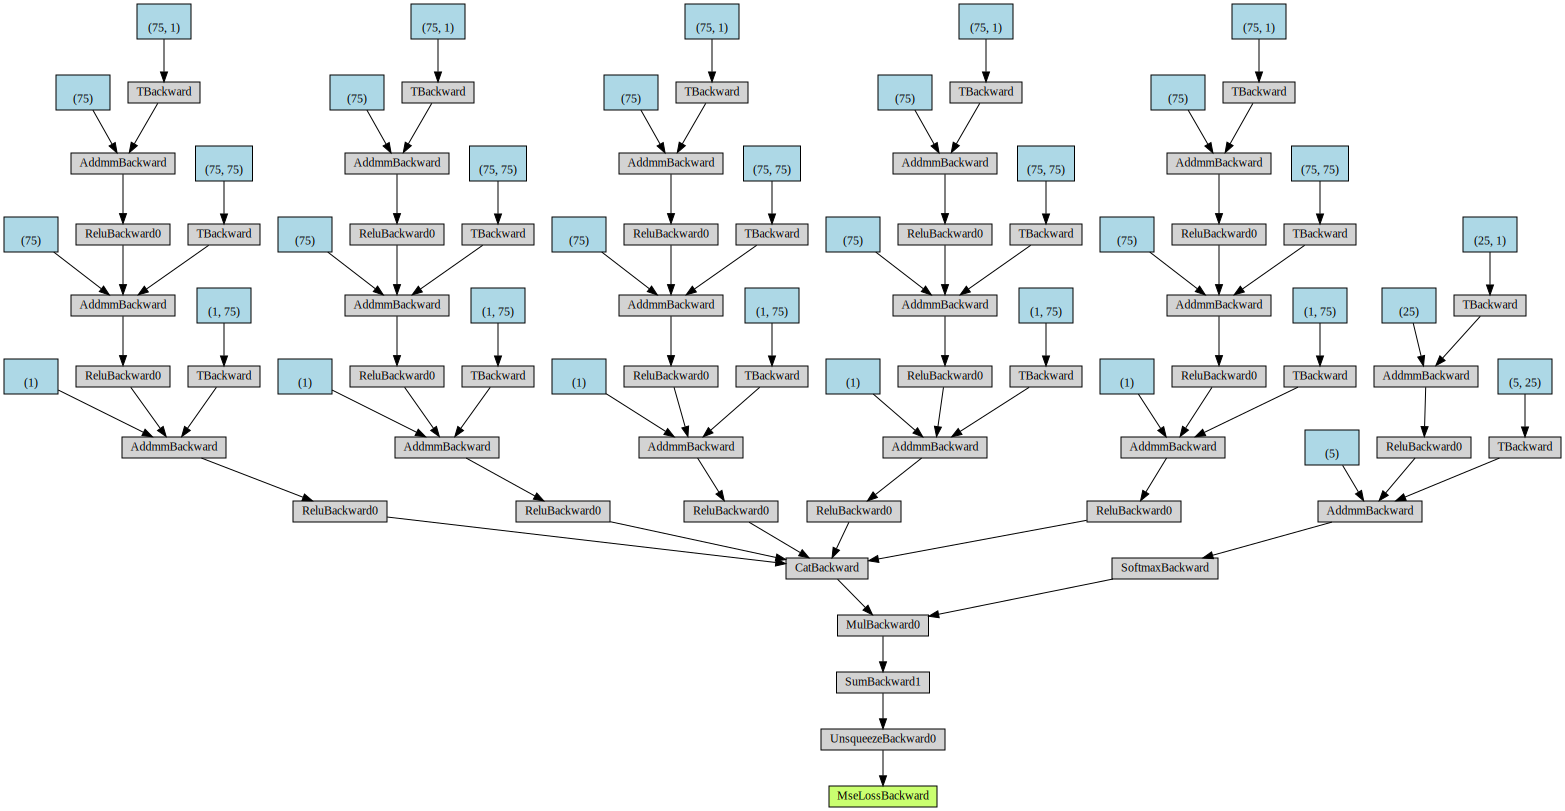

In [24]:
make_dot(agent.loss)

# Run

In [131]:
# x, y = create_mixed_data(5000)
x = np.linspace(-2, 2, 1000, dtype=np.float32)
y = linear_data(x)
x = x[np.newaxis].T.astype(np.float32)
y = y[np.newaxis].T.astype(np.float32)

In [132]:
agent = Agent(dim_shape=(1, 1), lr=0.001)
agent.fit(x, y, epochs=50, batch_size=40)

In [133]:
agent.plot_expert_usage()

In [125]:
predictions, expert_usage = agent.predict(x, return_expert_usage=True)

In [127]:
expert_usage

array([[0.8287813 , 0.17121866],
       [0.8282862 , 0.17171387],
       [0.8277898 , 0.17221019],
       ...,
       [0.32021016, 0.67978984],
       [0.31998253, 0.6800174 ],
       [0.31975496, 0.680245  ]], dtype=float32)

In [134]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x.squeeze(), y=predictions.squeeze(), name='predictions'))
fig.add_trace(go.Scatter(x=x.squeeze(), y=y.squeeze(), name='actual'))
fig.show()

In [135]:
# Prediction
agent.validate(x, y)